# 2D section inversion:
## Forward Model 1D: Empymod
## Inversion 1D: Pygimli inversion
## No lateral constraints

In [12]:
%matplotlib notebook

In [13]:
import empymod
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg

Dualem coil configurations:

In [14]:
# Receivers geometry

offsets = np.array([2, 4, 8]) # in meters
dip = np.array([0, 90])

Hreceivers = [offsets, offsets*0, 0, 0, 0]
Vreceivers = [offsets, offsets*0, 0, 0, 90]

# Source geometry

Hsource = [0, 0, 0 ,0 , 0]
Vsource = [0, 0, 0, 0, 90]

# Frequency

freq = 9000

In [15]:
# Create forward modeller class

class EMforward(pg.Modelling):
    
    def __init__(self):
        """Initialize the model."""
        super().__init__()
        
    def response(self, x):
        
        surface = np.array([0])
        thkx = np.array(x[0:2])
        depthx = np.hstack((surface, thkx[0], thkx[0]+thkx[1]))
        res_ground = np.array(x[2:])
        res_air = np.array([2e14])
        resx = np.hstack((res_air, res_ground))
        HCP = empymod.loop(Hsource, Hreceivers, depthx, resx, freq, xdirect=None, mrec = 'loop', verb=0)
        VCP = empymod.loop(Vsource, Vreceivers, depthx, resx, freq, xdirect=None, mrec = 'loop', verb=0)
        PRP = empymod.loop(Hsource, Vreceivers, depthx, resx, freq, xdirect=None, mrec = 'loop', verb=0)
        Z = np.hstack((HCP.real, HCP.imag, VCP.real, VCP.imag, PRP.real, PRP.imag))
        return Z
        
    def createStartModel(self, dataVals):
        
        thk_ini = [3, 4]
        res_ini = [12, 15, 18]
        x0 = thk_ini + res_ini
        return np.array(x0)

In [16]:
# parameters for the synthetic model

nlayer = 3 # number of layer
npos = 20 # number of sampling positions

resistivities = [10,50,10]
res = np.ones((npos, nlayer))*resistivities
x = np.linspace(0, 20, npos)[:,None]
thk1 = 2 + 0.2 * np.sin(x*np.pi*2) # wave
thk2 = 2 + np.sin(x*np.pi*2) # wave
depthmax = 10
ny = 50



In [17]:
# Arrays for plotting
y = np.linspace(0, depthmax, ny)
xx = np.linspace(0,npos+1,npos+1, endpoint=False) # For step plot

def PlotResistivities(thk1, thk2, res, npos, ny, Model):
    surface = np.zeros(npos)
    depth = np.zeros((npos,4))

    # Depths to be plotted
    for i in range(npos):
        depth[i,0] = 0
        depth[i,1] = thk1[i]
        depth[i,2] = thk1[i] + thk2[i]
        depth[i,3] = thk1[i] + thk2[i]
        
    resy = np.zeros((npos, ny))

    # Resistivities array to be plotted
    for i in range(npos):
        y1=0
        while y[y1] <= depth[i, 1]:
            resy[i, y1] = res[i, 0]
            y1 += 1
            y2=y1
        while y[y2] <= depth[i, 2]:
            resy[i, y2] = res[i, 1]
            y2 += 1
            if y2 == 50:
                break
        resy[i, y2:] = res[i, 2]
        
    fig, ax = plt.subplots()
    pos = ax.imshow(resy.T, cmap='viridis', interpolation='none', extent=[0,npos,10,0], vmin=10, vmax=50)
    clb = fig.colorbar(pos, shrink=0.5)
    clb.set_label('Resistivity [Ohm . m]',  )
    ax.set_ylabel('Depth [m]')
    ax.set_xlabel('Position [m]')
    ax.set_title(Model)
        
    return depth, resy

<IPython.core.display.Javascript object>


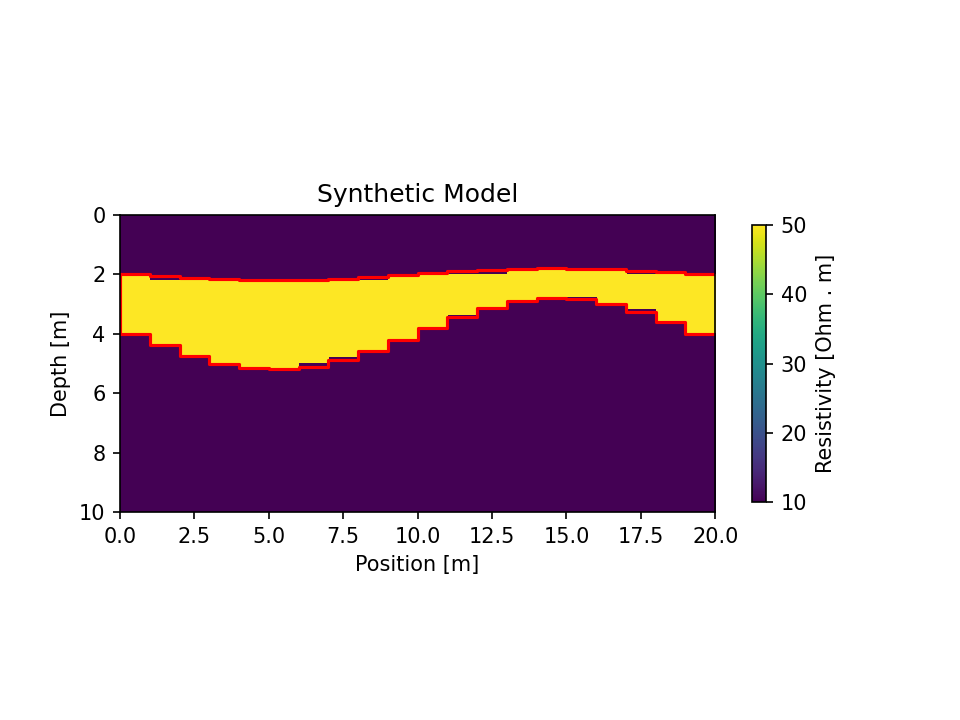

In [18]:
#Plot synthetic model

depth, resy = PlotResistivities(thk1, thk2, res, npos, ny, 'Synthetic Model')

plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,1],depth[-1,1])), 'r')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,2],depth[-1,2])),'r')




In [19]:
# Parameters for initial model

resistivities_ini = [10, 10, 10]
res_ini = np.ones((npos, nlayer))*resistivities_ini
thk1_ini = np.ones(npos)*3
thk2_ini = np.ones(npos)*4


<IPython.core.display.Javascript object>


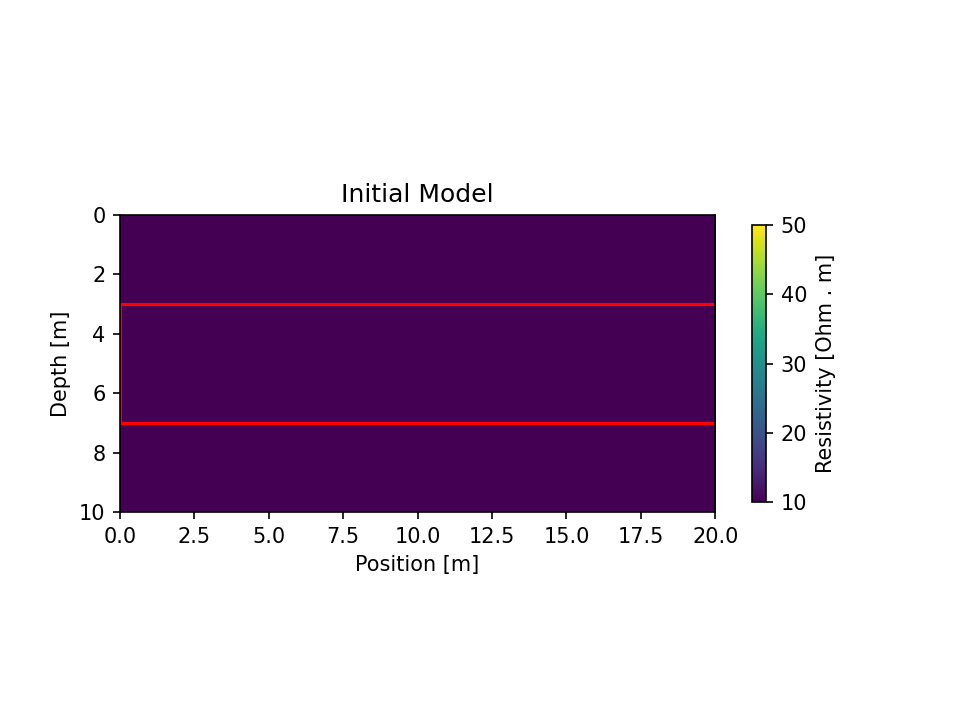

In [20]:
# Plot initial model

depth_ini, resy_ini = PlotResistivities(thk1_ini, thk2_ini, res_ini, npos, ny, 'Initial Model')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depth_ini[0,1], depth_ini[:,1], depth_ini[-1,1])), 'r')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depth_ini[0,1], depth_ini[:,2], depth_ini[-1,2])),'r')

Set-up Inversion

In [21]:
# Define inversion transformations

transData = pg.trans.TransLin() # log transformation for data
transModel = pg.trans.TransLogLU(1,1000)  # log-transform ensures thk>0

# Create inversion

EMf = EMforward()
invEM = pg.Inversion()
invEM.setForwardOperator(EMf)

invEM.transModel = transModel
invEM.transData = transData


In [22]:
# Inputs for inversion:

# Create empty array for true model in each position
model = []

# Create empty array for true data in each position
data = []

for i in range(npos):
    model_i = np.array([thk1[i][0], thk2[i][0]]+resistivities) # True model 
    model.append(model_i)
    data.append(EMf(model_i)) # creating data

# Relative error array
error = 1e-2 # introduce here the error you want to test
relativeError = np.ones_like(data[0]) * error

In [25]:
# Start inversion

model_est_list =[] # empty array to store the model estimated

for i in range(npos):
    
    dataE = np.array(data[i]).copy()
    dataE *= np.random.randn(len(dataE)) * relativeError + 1.0

    model_est = invEM.run(dataE, relativeError, verbose=True, lam=1, maxIter=20, dPhi=0.01)
    
    model_est_list.append(model_est)

# Model estimation array    
model_est_arr = np.array(model_est_list)

07/10/22 - 14:45:24 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
07/10/22 - 14:45:24 - pyGIMLi - INFO - Starting inversion.


fop: <__main__.EMforward object at 0x00000137929F1B30>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000013792CEC100>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000137929F1C20>
min/max (data): -6.5e-07/4.6e-06
min/max (error): 1%/1%
min/max (start model): 3/18
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 18.13 (dPhi = 93.77%) lam: 1
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 2.17 (dPhi = 82.64%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 1.36 (dPhi = 23.41%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 5 ... 

07/10/22 - 14:45:25 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
07/10/22 - 14:45:25 - pyGIMLi - INFO - Starting inversion.


chi² = 0.91 (dPhi = 16.32%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.91)                   #
################################################################################
fop: <__main__.EMforward object at 0x00000137929F1B30>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000013792ECEFA0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000137929F1C20>
min/max (data): -6.5e-07/4.7e-06
min/max (error): 1%/1%
min/max (start model): 3/18
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 43.63 (dPhi = 84.52%) lam: 1
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 26.39 (dPhi = 38.41%) lam: 1.0
----------------------------------------------------------------------------

07/10/22 - 14:45:25 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
07/10/22 - 14:45:25 - pyGIMLi - INFO - Starting inversion.


chi² = 2.77 (dPhi = 17.85%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 6 ... chi² = 0.85 (dPhi = 46.74%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.85)                   #
################################################################################
fop: <__main__.EMforward object at 0x00000137929F1B30>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000013792CEC100>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000137929F1C20>
min/max (data): -6.8e-07/4.7e-06
min/max (error): 1%/1%
min/max (start model): 3/18
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 60.31 (dPhi = 79.47%) lam: 1
-----------------------------------------------------------------------------

07/10/22 - 14:45:25 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
07/10/22 - 14:45:25 - pyGIMLi - INFO - Starting inversion.


chi² = 1.12 (dPhi = 0.08%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 16 ... chi² = 1.13 (dPhi = 0.0%) lam: 1.0
################################################################################
#                 Abort criteria reached: dPhi = 0.0 (< 0.01%)                 #
################################################################################
fop: <__main__.EMforward object at 0x00000137929F1B30>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000013792ECEFA0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000137929F1C20>
min/max (data): -6.8e-07/4.8e-06
min/max (error): 1%/1%
min/max (start model): 3/18
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 304.1 (dPhi = 8.39%) lam: 1
--------------------------------------------------------------------------------
i

07/10/22 - 14:45:26 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
07/10/22 - 14:45:26 - pyGIMLi - INFO - Starting inversion.


chi² = 2.78 (dPhi = 42.39%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 10 ... chi² = 0.84 (dPhi = 47.79%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.84)                   #
################################################################################
fop: <__main__.EMforward object at 0x00000137929F1B30>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000013792CEC100>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000137929F1C20>
min/max (data): -6.8e-07/4.8e-06
min/max (error): 1%/1%
min/max (start model): 3/18
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 252.72 (dPhi = 16.45%) lam: 1
---------------------------------------------------------------------------

07/10/22 - 14:45:26 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
07/10/22 - 14:45:26 - pyGIMLi - INFO - Starting inversion.


chi² = 1.29 (dPhi = 8.49%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 10 ... chi² = 1.09 (dPhi = 7.15%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 11 ... chi² = 0.94 (dPhi = 5.66%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.94)                   #
################################################################################
fop: <__main__.EMforward object at 0x00000137929F1B30>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000001379334FC40>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000137929F1C20>
min/max (data): -6.8e-07/4.7e-06
min/max (error): 1%/1%
min/max (start model): 3/18
--------------------------------------------------------------------------------
-----------------------------------------------------------------------------

07/10/22 - 14:45:27 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
07/10/22 - 14:45:27 - pyGIMLi - INFO - Starting inversion.


chi² = 48.87 (dPhi = 81.11%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 1.37 (dPhi = 94.56%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 5 ... chi² = 1.11 (dPhi = 9.29%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 6 ... chi² = 1.11 (dPhi = 0.03%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 7 ... chi² = 1.11 (dPhi = 0.01%) lam: 1.0
################################################################################
#                Abort criteria reached: dPhi = 0.01 (< 0.01%)                 #
################################################################################
fop: <__main__.EMforward object at 0x00000137929F1B30>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000013792CEC100>
Model transformation: <pgcore._pygimli_.RTransLog object at

07/10/22 - 14:45:27 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
07/10/22 - 14:45:27 - pyGIMLi - INFO - Starting inversion.


chi² = 29.34 (dPhi = 51.02%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 18.48 (dPhi = 35.6%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 5 ... chi² = 1.26 (dPhi = 86.61%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 6 ... chi² = 1.21 (dPhi = 2.91%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 7 ... chi² = 1.04 (dPhi = 6.09%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 8 ... chi² = 1.04 (dPhi = 0.0%) lam: 1.0
################################################################################
#                 Abort criteria reached: dPhi = 0.0 (< 0.01%)                 #
################################################################################
fop: <__main__.EMforward object at 0x00000137929F1B30>
Dat

07/10/22 - 14:45:27 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
07/10/22 - 14:45:27 - pyGIMLi - INFO - Starting inversion.


chi² = 16.19 (dPhi = 57.58%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 0.52 (dPhi = 89.23%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.52)                   #
################################################################################
fop: <__main__.EMforward object at 0x00000137929F1B30>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000013792CEC100>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000137929F1C20>
min/max (data): -6.6e-07/4.8e-06
min/max (error): 1%/1%
min/max (start model): 3/18
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 181.67 (dPhi = 38.75%) lam: 1
---------------------------------------------------------------------------

07/10/22 - 14:45:28 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
07/10/22 - 14:45:28 - pyGIMLi - INFO - Starting inversion.


chi² = 1.11 (dPhi = 2.04%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 15 ... chi² = 1.04 (dPhi = 3.19%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 16 ... chi² = 1.03 (dPhi = 0.06%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 17 ... chi² = 1.03 (dPhi = -0.0%) lam: 1.0
################################################################################
#                Abort criteria reached: dPhi = -0.0 (< 0.01%)                 #
################################################################################
fop: <__main__.EMforward object at 0x00000137929F1B30>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000001379334FC40>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000137929F1C20>
min/max (data): -6.4e-07/4.7e-06
min/max (error): 1%/1%
min/max (start model): 3/18
---------------------------

07/10/22 - 14:45:28 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
07/10/22 - 14:45:28 - pyGIMLi - INFO - Starting inversion.


chi² = 1.02 (dPhi = 0.04%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 6 ... chi² = 1.02 (dPhi = 0.05%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 7 ... chi² = 1.03 (dPhi = 0.07%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 8 ... chi² = 1.03 (dPhi = 0.07%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 9 ... chi² = 1.03 (dPhi = 0.05%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 10 ... chi² = 1.03 (dPhi = -0.0%) lam: 1.0
################################################################################
#                Abort criteria reached: dPhi = -0.0 (< 0.01%)                 #
################################################################################
fop: <__main__.EMforward object at 0x00000137929F1B30>
Data 

07/10/22 - 14:45:28 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
07/10/22 - 14:45:28 - pyGIMLi - INFO - Starting inversion.


chi² = 1.84 (dPhi = -1.28%) lam: 1.0
################################################################################
#                Abort criteria reached: dPhi = -1.28 (< 0.01%)                #
################################################################################
fop: <__main__.EMforward object at 0x00000137929F1B30>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000001379334FC40>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000137929F1C20>
min/max (data): -6.1e-07/4.7e-06
min/max (error): 1%/1%
min/max (start model): 3/18
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 150.16 (dPhi = 57.12%) lam: 1
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 68.74 (dPhi = 53.86%) lam: 1.0
-----------------------------------------------------------------------------

07/10/22 - 14:45:28 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
07/10/22 - 14:45:28 - pyGIMLi - INFO - Starting inversion.


chi² = 1.16 (dPhi = 79.06%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 7 ... chi² = 0.98 (dPhi = 7.36%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.98)                   #
################################################################################
fop: <__main__.EMforward object at 0x00000137929F1B30>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000013792CEC100>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000137929F1C20>
min/max (data): -5.8e-07/4.7e-06
min/max (error): 1%/1%
min/max (start model): 3/18
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 231.02 (dPhi = 38.45%) lam: 1
-----------------------------------------------------------------------------

07/10/22 - 14:45:29 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
07/10/22 - 14:45:29 - pyGIMLi - INFO - Starting inversion.


chi² = 1.03 (dPhi = 3.59%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 19 ... chi² = 0.98 (dPhi = 1.62%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.98)                   #
################################################################################
fop: <__main__.EMforward object at 0x00000137929F1B30>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000001379334FC40>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000137929F1C20>
min/max (data): -5.7e-07/4.8e-06
min/max (error): 1%/1%
min/max (start model): 3/18
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 189.14 (dPhi = 52.31%) lam: 1
-----------------------------------------------------------------------------

07/10/22 - 14:45:30 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
07/10/22 - 14:45:30 - pyGIMLi - INFO - Starting inversion.


chi² = 1.69 (dPhi = 78.16%) lam: 1.0
fop: <__main__.EMforward object at 0x00000137929F1B30>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000013792CEC100>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000137929F1C20>
min/max (data): -5.5e-07/4.9e-06
min/max (error): 1%/1%
min/max (start model): 3/18
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 161.74 (dPhi = 60.13%) lam: 1
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 44.73 (dPhi = 71.82%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 42.98 (dPhi = 3.85%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 5 ... chi² = 41.07 (dPhi = 4.37%) lam: 1.0
------------------------------------------------------

07/10/22 - 14:45:31 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
07/10/22 - 14:45:31 - pyGIMLi - INFO - Starting inversion.


chi² = 10.49 (dPhi = 24.92%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 12 ... chi² = 6.72 (dPhi = 32.49%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 13 ... chi² = 0.9 (dPhi = 74.21%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.90)                   #
################################################################################
fop: <__main__.EMforward object at 0x00000137929F1B30>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000001379334FC40>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000137929F1C20>
min/max (data): -5.5e-07/4.8e-06
min/max (error): 1%/1%
min/max (start model): 3/18
--------------------------------------------------------------------------------
--------------------------------------------------------------------------

07/10/22 - 14:45:31 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
07/10/22 - 14:45:31 - pyGIMLi - INFO - Starting inversion.


chi² = 15.22 (dPhi = 33.46%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 14 ... chi² = 8.66 (dPhi = 40.02%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 15 ... chi² = 6.5 (dPhi = 22.33%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 16 ... chi² = 0.76 (dPhi = 75.61%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.76)                   #
################################################################################
fop: <__main__.EMforward object at 0x00000137929F1B30>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000013792CEC100>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000137929F1C20>
min/max (data): -5.8e-07/4.7e-06
min/max (error): 1%/1%
min/max (start model): 3/18
---------------------

07/10/22 - 14:45:32 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
07/10/22 - 14:45:32 - pyGIMLi - INFO - Starting inversion.


chi² = 167.23 (dPhi = 54.55%) lam: 1
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 89.74 (dPhi = 46.07%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 22.36 (dPhi = 74.22%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 5 ... chi² = 0.76 (dPhi = 92.1%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.76)                   #
################################################################################
fop: <__main__.EMforward object at 0x00000137929F1B30>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000001379334FC40>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000137929F1C20>
min/max (data): -6.0e-07/4.7e-06
min/max (error): 1%/1%
min/max (start model): 3/18
-----------------------

07/10/22 - 14:45:32 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]


chi² = 126.84 (dPhi = 19.5%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 49.16 (dPhi = 60.73%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 5 ... chi² = 18.62 (dPhi = 60.76%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 6 ... chi² = 3.41 (dPhi = 76.72%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 7 ... chi² = 2.35 (dPhi = 23.74%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 8 ... chi² = 0.37 (dPhi = 56.29%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.37)                   #
################################################################################


07/10/22 - 14:45:32 - pyGIMLi - INFO - Starting inversion.


fop: <__main__.EMforward object at 0x00000137929F1B30>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000013792CEC100>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000137929F1C20>
min/max (data): -6.3e-07/4.7e-06
min/max (error): 1%/1%
min/max (start model): 3/18
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 107.23 (dPhi = 67.91%) lam: 1
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 45.86 (dPhi = 56.64%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 11.56 (dPhi = 73.0%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 5 ... chi² = 2.93 (dPhi = 67.62%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 6

07/10/22 - 14:45:32 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
07/10/22 - 14:45:32 - pyGIMLi - INFO - Starting inversion.


chi² = 0.7 (dPhi = 54.86%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.70)                   #
################################################################################
fop: <__main__.EMforward object at 0x00000137929F1B30>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000001379334FC40>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000137929F1C20>
min/max (data): -6.3e-07/4.7e-06
min/max (error): 1%/1%
min/max (start model): 3/18
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 20.95 (dPhi = 92.66%) lam: 1
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 11.68 (dPhi = 41.62%) lam: 1.0
-----------------------------------------------------------------------------

<IPython.core.display.Javascript object>


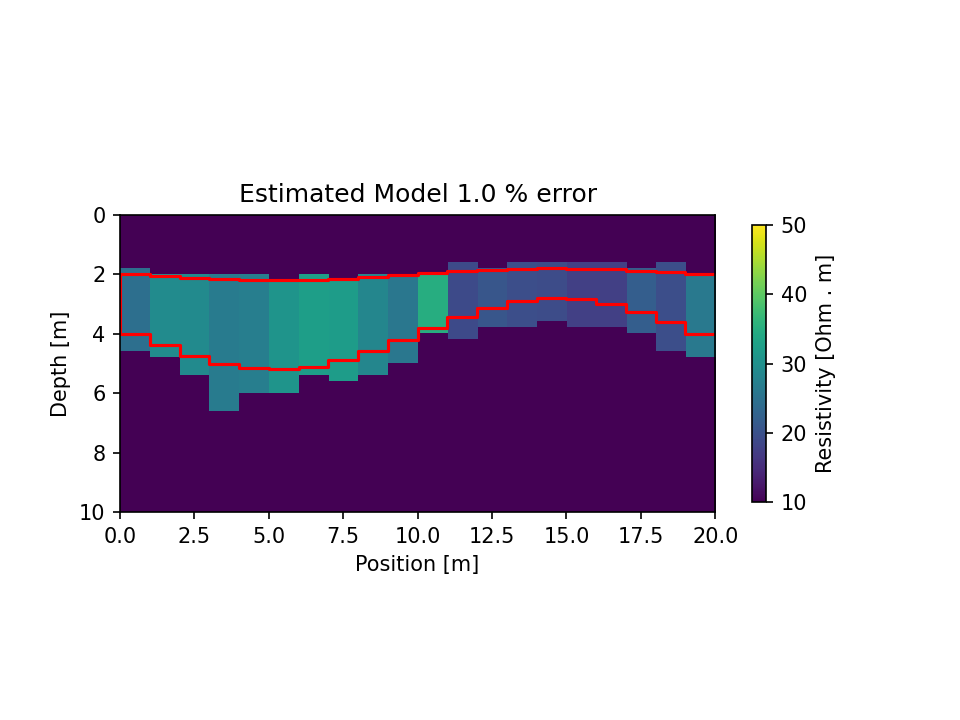

In [26]:
# Plot estimated model

depth_,resy_ = PlotResistivities(model_est_arr[:,0], model_est_arr[:,1], model_est_arr[:,2:] , npos, ny,
                                 'Estimated Model ' + str(error*100) + ' % error')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,1],depth[-1,1])), 'r')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,2],depth[-1,2])), 'r')

